# Geospatial Data Exploration

In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import datetime

NYC Neighborhood data contain 5 columns
- neighborhood
- boroughCode
- borough
- @id
- geometry

In [20]:
# Read in the data
data = pd.read_csv("/Users/yu-shenglee/Desktop/folder/data/Motor_Vehicle_Collisions_-_Crashes_20241124.csv", dtype={'ZIP CODE':str}, parse_dates=[ 'CRASH DATE','CRASH TIME'])
data.columns = [column.lower().replace(' ','_') for column in data.columns]

# Read in nyc_neighhorhood data
nyc_neighborhoods = gpd.read_file('/Users/yu-shenglee/Desktop/folder/data/nyc_neighborhoods.geojson')

# geo_data set up
geo_data = data.dropna(subset=['on_street_name', 'location'])
geo_data = geo_data[geo_data['crash_date'] > datetime.datetime(2019, 1, 1)]
points = geo_data.apply(lambda row: Point(row.longitude, row.latitude), axis = 1)
geo_data = gpd.GeoDataFrame(geo_data, geometry=points)
geo_data.crs = {'init': str(nyc_neighborhoods.crs)}
geo_data_w_neighborhoods = gpd.sjoin(geo_data, nyc_neighborhoods, how='inner', predicate="within")
geo_data_w_neighborhoods.dtypes

/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/c9/wtcfhbsj4_ggwscrqd_3_rpw0000gn/T/ipykernel_14550/4256522804.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  geo_data_w_neighborhoods = gpd.sjoin(geo_data, nyc_neighborhoods, how='inner', predicate="within")


crash_date                       datetime64[ns]
crash_time                       datetime64[ns]
borough_left                             object
zip_code                                 object
latitude                                float64
longitude                               float64
location                                 object
on_street_name                           object
cross_street_name                        object
off_street_name                          object
number_of_persons_injured               float64
number_of_persons_killed                float64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
contributing_factor_vehicle_3           

# Crash Frequency by Road Users
In what district, what kind of road users are more likely to be involved in a crash?

First, look at in each event how many people were involved in a crash?
- Look at borough that is most likely to have most people involved in an accident

Then, aggregate for each crash event: how many pedestrians, motorist, and cyclist were involved in each crash
- We can see in what borough and neighborhood what kind of accidents most likely to happen?


In [21]:
crash_by_road_user = geo_data_w_neighborhoods[['crash_date', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'collision_id', 
       'geometry', 'neighborhood', 'borough_right']]

crash_by_road_user['number_of_persons_involved'] = crash_by_road_user['number_of_persons_injured'] + crash_by_road_user['number_of_persons_killed']
crash_by_road_user['number_of_pedestrians_involved'] = crash_by_road_user['number_of_pedestrians_injured'] + crash_by_road_user['number_of_pedestrians_killed']
crash_by_road_user['number_of_cyclists_involved'] = crash_by_road_user['number_of_cyclist_injured'] + crash_by_road_user['number_of_cyclist_killed']
crash_by_road_user['number_of_motorists_involved'] = crash_by_road_user['number_of_motorist_injured'] + crash_by_road_user['number_of_motorist_killed']


/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yu-shenglee/ENTER/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [ ]:
# crash_by_road_user[crash_by_road_user['number_of_cyclists_involved']>0]

geopandas.geodataframe.GeoDataFrame

In [24]:
crash_table=crash_by_road_user.groupby(by='borough_right')['number_of_persons_involved','number_of_pedestrians_involved','number_of_cyclists_involved','number_of_motorists_involved'].sum().sort_values(by='number_of_persons_involved', ascending=False)

/var/folders/c9/wtcfhbsj4_ggwscrqd_3_rpw0000gn/T/ipykernel_14550/1852973070.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crash_table=crash_by_road_user.groupby(by='borough_right')['number_of_persons_involved','number_of_pedestrians_involved','number_of_cyclists_involved','number_of_motorists_involved'].sum().sort_values(by='number_of_persons_involved', ascending=False)


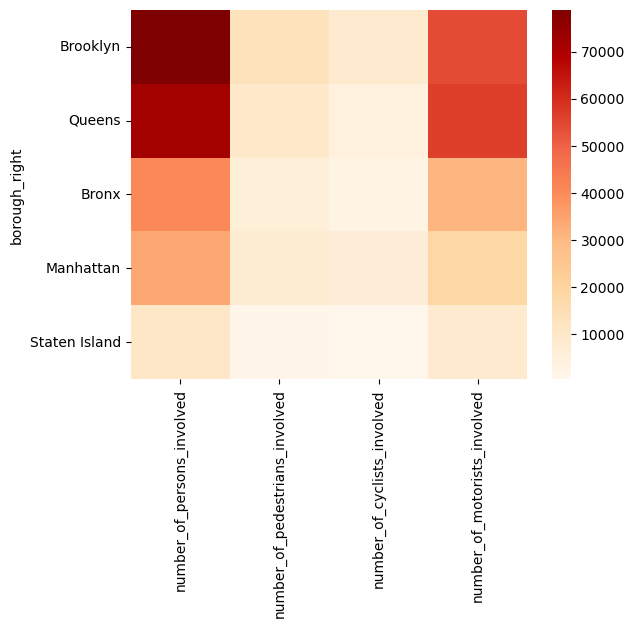

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt 

# plotting the heatmap 
hm = sns.heatmap(data = crash_table, cmap='OrRd') 
  
# displaying the plotted heatmap 
plt.show()

In [31]:
crash_by_road_user.groupby(by=['borough_right','neighborhood'])['number_of_persons_involved','number_of_pedestrians_involved','number_of_cyclists_involved','number_of_motorists_involved'].sum()

/var/folders/c9/wtcfhbsj4_ggwscrqd_3_rpw0000gn/T/ipykernel_14550/386602071.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crash_by_road_user.groupby(by=['borough_right','neighborhood'])['number_of_persons_involved','number_of_pedestrians_involved','number_of_cyclists_involved','number_of_motorists_involved'].sum()


number_of_persons_involved  \
borough_right neighborhood                                
Bronx         Allerton                            718.0   
              Baychester                          547.0   
              Belmont                             802.0   
              Bronx Park                          992.0   
              Bronxdale                           148.0   
...                                                 ...   
Staten Island Tottenville                         169.0   
              West Brighton                       224.0   
              Westerleigh                         233.0   
              Willowbrook                          46.0   
              Woodrow                             318.0   

                             number_of_pedestrians_involved  \
borough_right neighborhood                                    
Bronx         Allerton                                  125   
              Baychester                                 63   
              Belmont                                   171   
              Bronx Park                                 40   
              Bronxdale                                  41   
...                                                     ...   
Staten Island Tottenville                                29   
              West Brighton                              42   
              Westerleigh                                30   
              Willowbrook                                 7   
              Woodrow                                    29   

                             number_of_cyclists_involved  \
borough_right neighborhood                                 
Bronx         Allerton                                44   
              Baychester                              12   
              Belmont                                 63   
              Bronx Park                              13   
              Bronxdale                               14   
...                                                  ...   
Staten Island Tottenville                              9   
              West Brighton                           13   
              Westerleigh                             13   
              Willowbrook                              0   
              Woodrow                                 10   

                             number_of_motorists_involved  
borough_right neighborhood                                 
Bronx         Allerton                                529  
              Baychester                              467  
              Belmont                                 534  
              Bronx Park                              936  
              Bronxdale                                86  
...                                                   ...  
Staten Island Tottenville                             130  
              West Brighton                           164  
              Westerleigh                             190  
              Willowbrook                              39  
              Woodrow                                 277  

[254 rows x 4 columns]

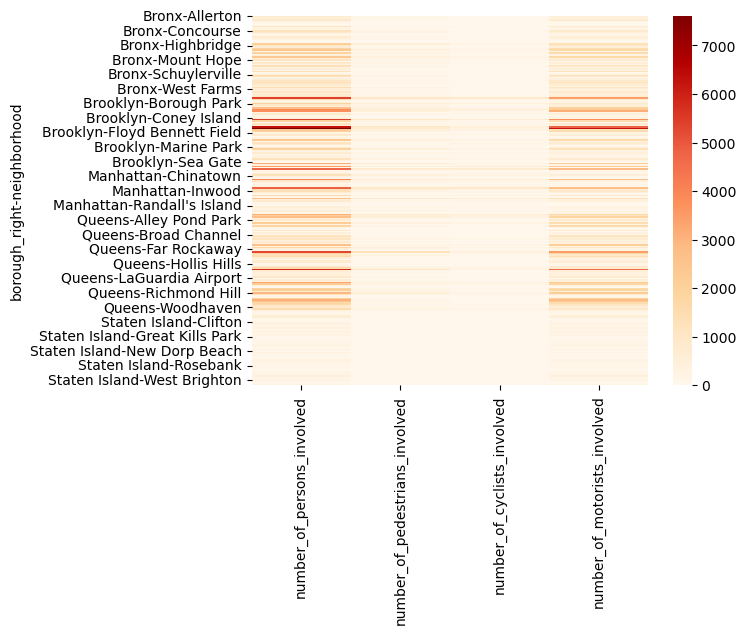

In [ ]:
# # plotting the heatmap 
# sns.heatmap(data = table_crash_by_road_user, cmap='OrRd') 
  
# # displaying the plotted heatmap 
# plt.show()

In [ ]:
# crash_by_road_user.pivot_table(
#        values='collision_id', 
#        index=['number_of_persons_involved','number_of_pedestrians_involved','number_of_cyclists_involved','number_of_motorists_involved'],
#        columns='borough_right', 
#        aggfunc='count',
# )


borough_right                                                                                                         Bronx  \
number_of_persons_involved number_of_pedestrians_involved number_of_cyclists_involved number_of_motorists_involved            
0.0                        0                              0                           0                             48493.0   
1.0                        0                              0                           0                               822.0   
                                                                                      1                             12484.0   
                                                          1                           0                              2384.0   
                           1                              0                           0                              5528.0   
...                                                                                                                     ...   
20.0                       0                              0                           20                                NaN   
21.0                       19                             0                           2                                 NaN   
23.0                       0                              0                           23                                NaN   
25.0                       0                              0                           25                                NaN   
34.0                       0                              0                           34                                NaN   

borough_right                                                                                                       Brooklyn  \
number_of_persons_involved number_of_pedestrians_involved number_of_cyclists_involved number_of_motorists_involved             
0.0                        0                              0                           0                              90163.0   
1.0                        0                              0                           0                               2414.0   
                                                                                      1                              22634.0   
                                                          1                           0                               8364.0   
                           1                              0                           0                              11713.0   
...                                                                                                                      ...   
20.0                       0                              0                           20                                 NaN   
21.0                       19                             0                           2                                  NaN   
23.0                       0                              0                           23                                 NaN   
25.0                       0                              0                           25                                 NaN   
34.0                       0                              0                           34                                 NaN   

borough_right                                                                                                       Manhattan  \
number_of_persons_involved number_of_pedestrians_involved number_of_cyclists_involved number_of_motorists_involved              
0.0                        0                              0                           0                               55219.0   
1.0                        0                              0                           0                                 935.0   
                                                                                      1                                8698.0   
                                      

# Contribution factor in each neighborhood

In [33]:
crash_factor_by_borough = geo_data_w_neighborhoods[
       ['crash_date', 'contributing_factor_vehicle_1','collision_id', 'geometry', 'neighborhood', 'borough_right']]

pivot_table = crash_factor_by_borough.pivot_table(
       values='collision_id', 
       index='contributing_factor_vehicle_1',
       columns='borough_right', 
       aggfunc='count',
       margins=True).fillna(0).sort_values(by='All', ascending=False).head(10)

percentage_pivot_table = pivot_table.div(pivot_table.loc[:, 'All'], axis=0) * 100

percentage_pivot_table = percentage_pivot_table.drop('All', axis=0).drop('All', axis=1) # remove the 'All' row and column

percentage_pivot_table

borough_right,Bronx,Brooklyn,Manhattan,Queens,Staten Island
contributing_factor_vehicle_1,,,,,
Driver Inattention/Distraction,12.918763,31.261031,19.521649,31.430103,4.868454
Unspecified,20.430339,36.554350,15.376106,24.628984,3.010220
Failure to Yield Right-of-Way,12.468573,31.304608,13.372165,38.192318,4.662335
Following Too Closely,13.681794,27.493247,15.310643,39.486764,4.027553
Passing or Lane Usage Improper,13.246654,30.240368,19.929953,33.133426,3.449599
Passing Too Closely,17.447663,32.315769,20.396656,27.927928,1.911984
Traffic Control Disregarded,16.255732,33.667841,15.092710,31.042733,3.940985
Unsafe Speed,22.302006,27.356565,12.467441,33.058782,4.815206
Other Vehicular,25.261506,29.116856,23.326360,19.814704,2.480574


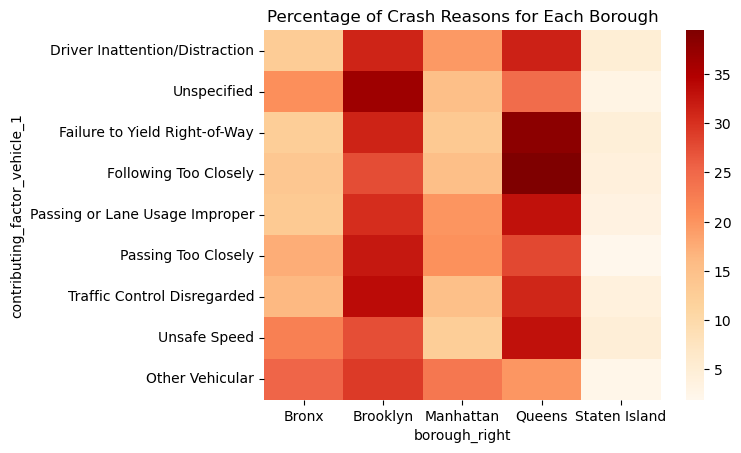

In [ ]:
# plotting the heatmap 
sns.heatmap(data = percentage_pivot_table, cmap='OrRd') 
  
# displaying the plotted heatmap 
plt.title('Percentage of Crash Reasons For Each Borough')
plt.show()

# Vehicle Type

In [42]:
by_vehicle_type = geo_data_w_neighborhoods[['crash_date', 
       'collision_id', 'vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5',
       'geometry', 'neighborhood',
       'borough_right']]
by_vehicle_type

,crash_date,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,geometry,neighborhood,borough_right
4,2021-12-14,4486609,NaN,NaN,NaN,NaN,NaN,POINT (-73.91727 40.6833),Bedford-Stuyvesant,Brooklyn
6,2021-12-14,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN,POINT (-73.95682 40.70918),Williamsburg,Brooklyn
9,2021-12-14,4486519,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.97397 40.75144),Midtown,Manhattan
10,2021-12-13,4486934,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.88887 40.70128),Glendale,Queens
11,2021-12-14,4487127,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.75577 40.67588),Springfield Gardens,Queens
...,...,...,...,...,...,...,...,...,...,...
2136366,2024-08-06,4745716,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.76171 40.74738),Bayside,Queens
2136368,2024-08-06,4746029,Station Wagon/Sport Utility Vehicle,Tractor Truck Diesel,NaN,NaN,NaN,POINT (-73.74915 40.75108),Bayside,Queens
2136369,2024-08-04,4746578,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,POINT (-74.09576 40.61051),Todt Hill,Staten Island
2136373,2024-08-06,4745999,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.82226 40.66496),South Ozone Park,Queens


In [58]:
by_vehicle_type.vehicle_type_code_1.value_counts().head(10)
# by_vehicle_type_brooklyn = by_vehicle_type[by_vehicle_type['borough_right'] == 'Brooklyn'] 
# by_vehicle_type_brooklyn.vehicle_type_code_1.value_counts()
# by_vehicle_type.groupby(by='borough_right')

Sedan                                  215528
Station Wagon/Sport Utility Vehicle    168488
Taxi                                    17085
Pick-up Truck                           11389
Bus                                      8417
Box Truck                                7876
Bike                                     6680
Tractor Truck Diesel                     3698
Motorcycle                               3666
Van                                      2602
Name: vehicle_type_code_1, dtype: int64

In [65]:
# Step 1: Melt the DataFrame to gather the value columns into one 
melted = by_vehicle_type.melt(id_vars="borough_right", value_vars=["vehicle_type_code_1", "vehicle_type_code_2", "vehicle_type_code_3","vehicle_type_code_4","vehicle_type_code_5"], value_name="value")
result = melted.groupby(["borough_right", "value"]).size().unstack()[['Sedan','Station Wagon/Sport Utility Vehicle','Taxi','Pick-up Truck','Bus','Box Truck','Bike','Tractor Truck Diesel','Motorcycle','Van']]
result

value,Sedan,Station Wagon/Sport Utility Vehicle,Taxi,Pick-up Truck,Bus,Box Truck,Bike,Tractor Truck Diesel,Motorcycle,Van
borough_right,,,,,,,,,,
Bronx,63397.0,47576.0,4392.0,3279.0,2829.0,2868.0,2269.0,2418.0,1223.0,851.0
Brooklyn,123476.0,94497.0,5266.0,6424.0,5198.0,5814.0,8786.0,2157.0,2395.0,1712.0
Manhattan,57235.0,43183.0,13716.0,3714.0,3957.0,5083.0,7836.0,746.0,1324.0,1517.0
Queens,122692.0,104967.0,4562.0,7728.0,3332.0,4314.0,4390.0,2153.0,2306.0,930.0
Staten Island,17823.0,12741.0,139.0,1526.0,622.0,299.0,406.0,245.0,338.0,92.0


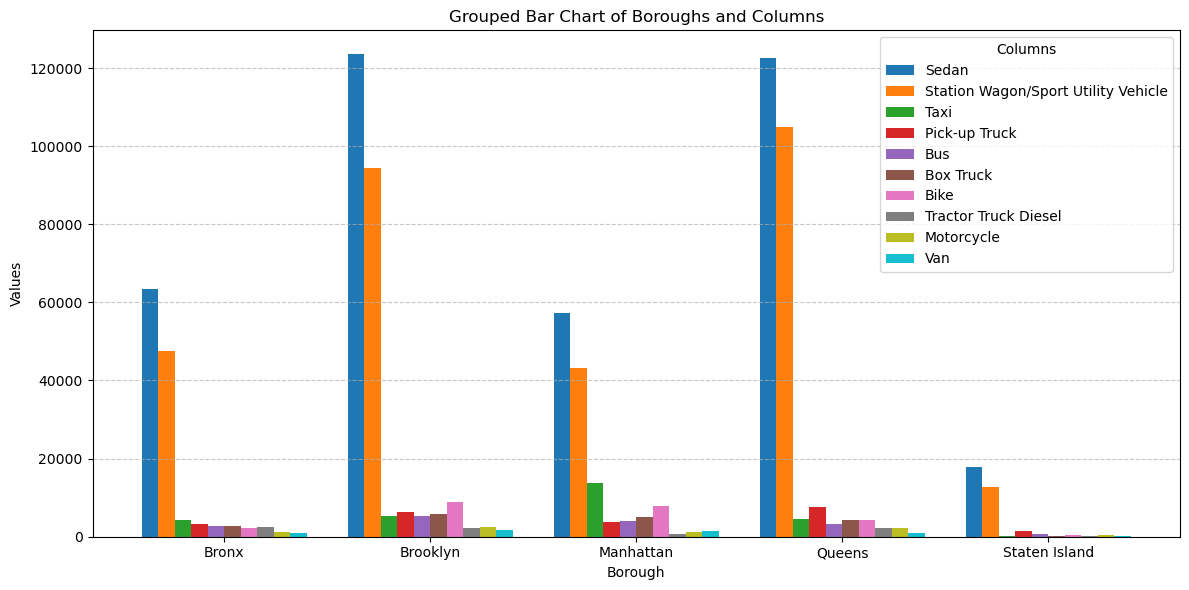

In [66]:
import numpy as np
# result.set_index("borough_right", inplace=True)
num_boroughs = result.shape[0] 
num_columns = result.shape[1]
# Set positions for the bars 
x = np.arange(num_boroughs) 
# The x locations for the groups 
width = 0.8 / num_columns
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each column to create bars 
for i, col in enumerate(result.columns): 
    ax.bar(x + i * width,result[col],width,label=col)
    
# Step 3: Customize the plot 
ax.set_xlabel("Borough") 
ax.set_ylabel("Values") 
ax.set_title("Grouped Bar Chart of Boroughs and Columns") 
ax.set_xticks(x + width * (num_columns - 1) / 2) 

# Center tick labels 
ax.set_xticklabels(result.index) 
# Use borough names as labels 
ax.legend(title="Columns")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()